<a href="https://colab.research.google.com/github/itsabhay22/Bulk_message_bombarder_whatapp-Telegram/blob/main/GH1046138_Abhay_Dhiman_M505_Intro_to_AI_and_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#INTRODUCTION



The automotive industry is quite competitive and pricing of cars is very critical in terms of profit, brand image and positioning in the market.

The project aims at making forecasts of the prices of cars within the U.S. market through machine learning, in the case of Geely Auto (a Chinese automobile company entering the U.S.).







#PROBLEM STATEMENT
The paper applies both the supervised learning (regression) and the unsupervised learning (clustering) methods to:

Precisely estimate the price of a car on the basis of car characteristics such as horsepower, engine size, and curb weight.

Define cars in the market (economy, mid-range, and premium) by clustering.

Purpose: Assist manufacturers and dealers in making improved pricing choices and learn the market dynamics with the help of data-driven methods.

#Key business question:

What are the most powerful features that define the price of a car?

How can machine learning be valuable in positioning new vehicles?

This section provides the basis of how AI can be used to help with strategic decisions in the auto industry.

# IMPORTING LIBRARIES

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, silhouette_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import joblib
import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

#DATA SOURCE
https://www.kaggle.com/datasets/hellbuoy/car-price-prediction

# Dataset load

In [ ]:
df = pd.read_csv("/content/CarPrice_Assignment.csv")
print("Dataset shape:", df.shape)
display(df.head())

Dataset shape: (205, 26)


,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


# Data Preprocessing

In [ ]:
print("\n--- dtypes ---")
print(df.dtypes)
print("\n--- missing values ---")
print(df.isna().sum())


--- dtypes ---
car_ID                int64
symboling             int64
CarName              object
fueltype             object
aspiration           object
doornumber           object
carbody              object
drivewheel           object
enginelocation       object
wheelbase           float64
carlength           float64
carwidth            float64
carheight           float64
curbweight            int64
enginetype           object
cylindernumber       object
enginesize            int64
fuelsystem           object
boreratio           float64
stroke              float64
compressionratio    float64
horsepower            int64
peakrpm               int64
citympg               int64
highwaympg            int64
price               float64
dtype: object

--- missing values ---
car_ID              0
symboling           0
CarName             0
fueltype            0
aspiration          0
doornumber          0
carbody             0
drivewheel          0
enginelocation      0
wheelbase           

In [ ]:
if "car_ID" in df.columns:
    df = df.drop(columns=["car_ID"])

In [ ]:
if "CarName" in df.columns:
    df["brand"] = df["CarName"].astype(str).str.split().str[0].str.lower()
    df = df.drop(columns=["CarName"])

In [ ]:
word_to_num = {'one':1,'two':2,'three':3,'four':4,'five':5,'six':6,'seven':7,'eight':8,'twelve':12}
if "cylindernumber" in df.columns and df["cylindernumber"].dtype == "object":
    df["cylindernumber"] = df["cylindernumber"].map(word_to_num)

In [ ]:
df["price"] = pd.to_numeric(df["price"], errors="coerce")

In [ ]:
df = df.dropna(subset=["price"]).reset_index(drop=True)
print("\nAfter basic cleaning shape:", df.shape)


After basic cleaning shape: (205, 25)


#Exploratory Analysis of Data (EDA)
First examination reveals that there are 205 records and not too many missing.

Outliers: Occurred in the horsepower and price.

Distribution: Price is skewed to the right (mostly mid-range cars).

Correlations: Price is strongly correlated with engine size, curb weight and horsepower.

Categorical information: Vehicles with rear-wheel drives and fuel-injected engines are priced higher. High end brands (BMW, Mercedes) are more expensive.

## Quick EDA (target & simple correlations)

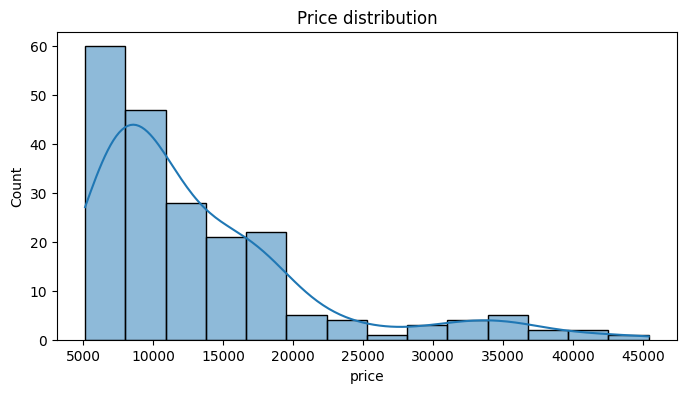

In [ ]:
plt.figure(figsize=(8,4))
sns.histplot(df["price"], kde=True)
plt.title("Price distribution")
plt.show()

In [ ]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c != "price"]
print("\nNumeric columns:", numeric_cols)


Numeric columns: ['symboling', 'wheelbase', 'carlength', 'carwidth', 'carheight', 'curbweight', 'cylindernumber', 'enginesize', 'boreratio', 'stroke', 'compressionratio', 'horsepower', 'peakrpm', 'citympg', 'highwaympg']


In [ ]:
corr_with_price = df[numeric_cols + ["price"]].corr()["price"].abs().sort_values(ascending=False)
print("\nTop correlations with price:")
print(corr_with_price.head(10))


Top correlations with price:
price             1.000000
enginesize        0.874145
curbweight        0.835305
horsepower        0.808139
carwidth          0.759325
cylindernumber    0.718305
highwaympg        0.697599
citympg           0.685751
carlength         0.682920
wheelbase         0.577816
Name: price, dtype: float64


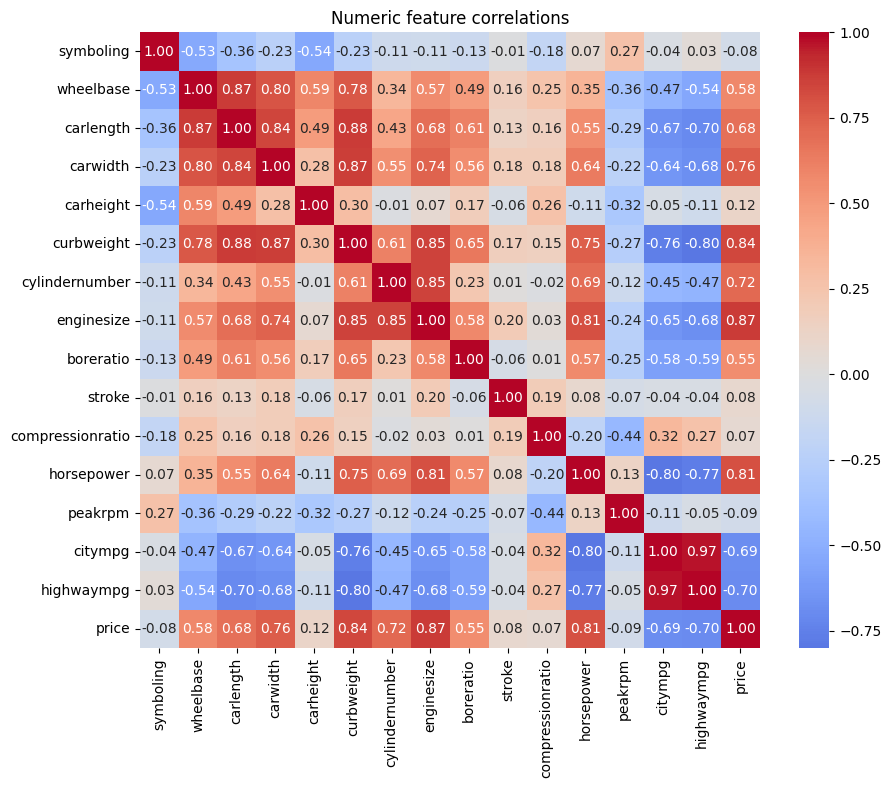

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(df[numeric_cols + ["price"]].corr(), annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Numeric feature correlations")
plt.show()

In [ ]:
cat_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()
print("\nCategorical columns:", cat_cols)
for c in cat_cols:
    print(f"\nTop values for {c}:")
    print(df[c].value_counts().head())


Categorical columns: ['fueltype', 'aspiration', 'doornumber', 'carbody', 'drivewheel', 'enginelocation', 'enginetype', 'fuelsystem', 'brand']

Top values for fueltype:
fueltype
gas       185
diesel     20
Name: count, dtype: int64

Top values for aspiration:
aspiration
std      168
turbo     37
Name: count, dtype: int64

Top values for doornumber:
doornumber
four    115
two      90
Name: count, dtype: int64

Top values for carbody:
carbody
sedan          96
hatchback      70
wagon          25
hardtop         8
convertible     6
Name: count, dtype: int64

Top values for drivewheel:
drivewheel
fwd    120
rwd     76
4wd      9
Name: count, dtype: int64

Top values for enginelocation:
enginelocation
front    202
rear       3
Name: count, dtype: int64

Top values for enginetype:
enginetype
ohc     148
ohcf     15
ohcv     13
dohc     12
l        12
Name: count, dtype: int64

Top values for fuelsystem:
fuelsystem
mpfi    94
2bbl    66
idi     20
1bbl    11
spdi     9
Name: count, dtype: int

In [ ]:
target = "price"
features = [c for c in df.columns if c != target]

In [ ]:
numeric_features = df[features].select_dtypes(include=[np.number]).columns.tolist()
categorical_features = df[features].select_dtypes(include=["object", "category"]).columns.tolist()

print("\nFinal numeric features:", numeric_features)
print("Final categorical features:", categorical_features)


Final numeric features: ['symboling', 'wheelbase', 'carlength', 'carwidth', 'carheight', 'curbweight', 'cylindernumber', 'enginesize', 'boreratio', 'stroke', 'compressionratio', 'horsepower', 'peakrpm', 'citympg', 'highwaympg']
Final categorical features: ['fueltype', 'aspiration', 'doornumber', 'carbody', 'drivewheel', 'enginelocation', 'enginetype', 'fuelsystem', 'brand']


#Preprocessing and Engineering of Data.

The data are prepared in various steps before it is trained to create the model:

Missing Data: Numeric: This will be filled with the median; categorical: with the mode.

Encoding - Convert text labels into one-hot numbers: (e.g., fuel type)

Scaling Features Standardization of the numeric variables in such a way that all features are equal.

Selection of features: Retaining only the useful and very correlated features so as to enhance the model performance.

Purpose: Clean and organize the dataset and make it machine-learning friendly.

# Train-test split (supervised)

In [ ]:
X = df[features].copy()
y = df[target].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (164, 24) Test: (41, 24)


# Preprocessing Pipeline

In [ ]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
])

# Helper evaluate function

In [ ]:
def evaluate_model(model, X_test, y_test):
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    print(f"RMSE: {rmse:.2f} | MAE: {mae:.2f} | R2: {r2:.3f}")
    return {"rmse": rmse, "mae": mae, "r2": r2}

# Supervised modeling: baseline comparison

In [ ]:
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(random_state=RANDOM_STATE),
    "Lasso": Lasso(random_state=RANDOM_STATE, max_iter=5000),
    "RandomForest": RandomForestRegressor(random_state=RANDOM_STATE),
    "GradientBoosting": GradientBoostingRegressor(random_state=RANDOM_STATE)
}

In [ ]:
cv_results = {}
for name, estimator in models.items():
    pipe = Pipeline(steps=[("preprocessor", preprocessor), ("model", estimator)])
    scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1)
    mean_rmse = -scores.mean()
    cv_results[name] = mean_rmse
    print(f"{name}: CV RMSE = {mean_rmse:.2f}")

LinearRegression: CV RMSE = 2761.54
Ridge: CV RMSE = 2355.71
Lasso: CV RMSE = 2575.30
RandomForest: CV RMSE = 2375.25
GradientBoosting: CV RMSE = 2428.79


In [ ]:
print("\nModel ranking by CV RMSE:")
for name, score in sorted(cv_results.items(), key=lambda x: x[1]):
    print(f"{name}: {score:.2f}")


Model ranking by CV RMSE:
Ridge: 2355.71
RandomForest: 2375.25
GradientBoosting: 2428.79
Lasso: 2575.30
LinearRegression: 2761.54


#Ridge Regression

Linear model that is regularized to deal with multicollinearity.

Benefit: Simple to interpret and determine the importance of the features.

Limit: May not work well when data would be having complicated non-linear relationships.

# Hyperparameter tuning for top models (Ridge & RandomForest)

In [ ]:
ridge_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", Ridge(random_state=RANDOM_STATE))
])

In [ ]:
rf_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(random_state=RANDOM_STATE))
])

In [ ]:
ridge_param_grid = {
    "model__alpha": [0.1, 1.0, 10.0, 50.0, 100.0]  # strength of regularization
}

rf_param_grid = {
    "model__n_estimators": [100, 200],
    "model__max_depth": [None, 6, 10],
    "model__min_samples_split": [2, 5]
}

cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

## GridSearch for Ridge


In [ ]:
print("\nTuning Ridge...")
ridge_search = GridSearchCV(ridge_pipe, ridge_param_grid, cv=cv,
                            scoring="neg_root_mean_squared_error", n_jobs=-1)
ridge_search.fit(X_train, y_train)
print("Ridge best params:", ridge_search.best_params_)
print("Ridge best CV RMSE:", -ridge_search.best_score_)


Tuning Ridge...
Ridge best params: {'model__alpha': 1.0}
Ridge best CV RMSE: 2573.709031240204


## GridSearch for RandomForest
Random Forest Regressor

A model that integrates a number of decision trees.

In [ ]:
print("\nTuning RandomForest...")
rf_search = GridSearchCV(rf_pipe, rf_param_grid, cv=cv,
                         scoring="neg_root_mean_squared_error", n_jobs=-1)
rf_search.fit(X_train, y_train)
print("RF best params:", rf_search.best_params_)
print("RF best CV RMSE:", -rf_search.best_score_)


Tuning RandomForest...
RF best params: {'model__max_depth': 10, 'model__min_samples_split': 2, 'model__n_estimators': 200}
RF best CV RMSE: 2493.738662368207


## Final evaluation on hold-out test set

In [ ]:
print("\n-- Test set evaluation --")
ridge_best = ridge_search.best_estimator_
rf_best = rf_search.best_estimator_

print("Ridge on test:")
ridge_metrics = evaluate_model(ridge_best, X_test, y_test)

print("\nRandomForest on test:")
rf_metrics = evaluate_model(rf_best, X_test, y_test)


-- Test set evaluation --
Ridge on test:
RMSE: 2892.92 | MAE: 1999.53 | R2: 0.894

RandomForest on test:
RMSE: 1812.94 | MAE: 1257.74 | R2: 0.958


#Model Evaluation Metrics:

R2(Coefficient of Determination): The extent of variance covered by the model.

## Compare and choose final supervised model

In [ ]:
if ridge_metrics["rmse"] <= rf_metrics["rmse"]:
    final_model = ridge_best
    final_model_name = "Ridge"
    final_metrics = ridge_metrics
else:
    final_model = rf_best
    final_model_name = "RandomForest"
    final_metrics = rf_metrics

print(f"\nSelected final supervised model: {final_model_name}")


Selected final supervised model: RandomForest


# Interpretability (Permutation importance only if final model is RandomForest)


Computing permutation importance (this may take a little while)...


,feature,importance_mean,importance_std
7,enginesize,0.839546,0.138137
5,curbweight,0.132680,0.021990
14,highwaympg,0.007924,0.003606
11,horsepower,0.004831,0.002575
3,carwidth,0.004076,0.002438
10,compressionratio,0.003328,0.002375
13,citympg,0.002639,0.002034
2,carlength,0.002117,0.000854
9,stroke,0.001737,0.000894
48,brand_bmw,0.001337,0.001004


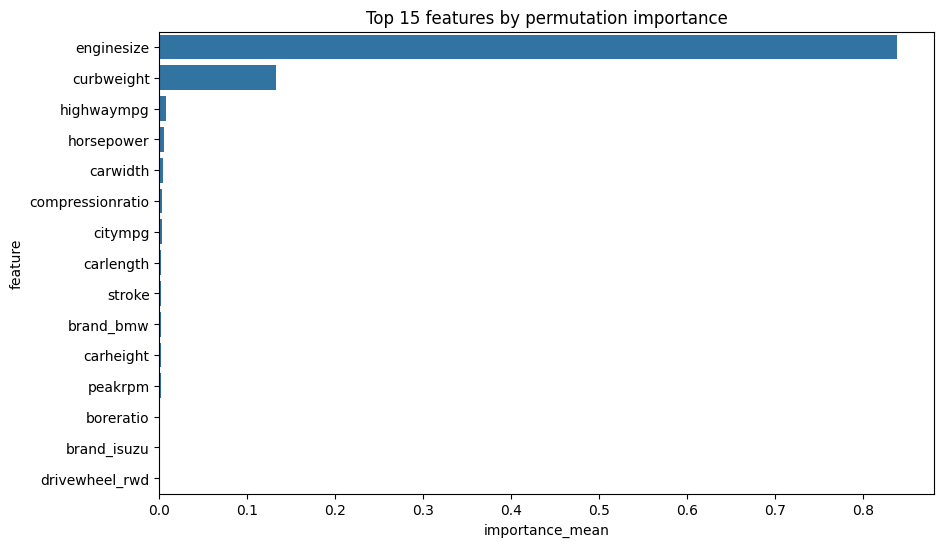

In [ ]:
if final_model_name == "RandomForest":
    print("\nComputing permutation importance (this may take a little while)...")
    X_test_processed = final_model.named_steps["preprocessor"].transform(X_test)

    perm = permutation_importance(final_model.named_steps["model"], X_test_processed, y_test,
                                  n_repeats=10, random_state=RANDOM_STATE, n_jobs=-1)

    pre = final_model.named_steps["preprocessor"]
    num_names = numeric_features
    cat_names = []
    if len(categorical_features) > 0:
        onehot = pre.named_transformers_["cat"].named_steps["onehot"]
        cat_names = list(onehot.get_feature_names_out(categorical_features))

    feature_names = num_names + cat_names

    if len(feature_names) != X_test_processed.shape[1]:
        print("Warning: Number of feature names does not match number of features in processed data.")
        feature_names = [f"feature_{i}" for i in range(X_test_processed.shape[1])]


    imp_df = pd.DataFrame({
        "feature": feature_names,
        "importance_mean": perm.importances_mean,
        "importance_std": perm.importances_std
    }).sort_values(by="importance_mean", ascending=False)

    display(imp_df.head(15))

    plt.figure(figsize=(10,6))
    sns.barplot(x="importance_mean", y="feature", data=imp_df.head(15))
    plt.title("Top 15 features by permutation importance")
    plt.show()

# Residual diagnostics

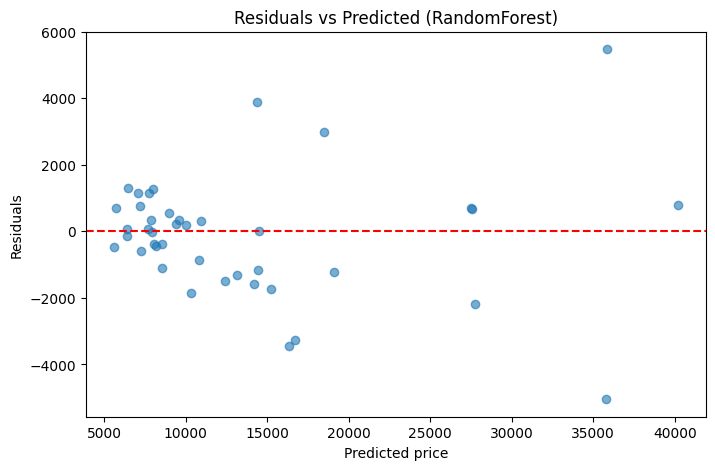

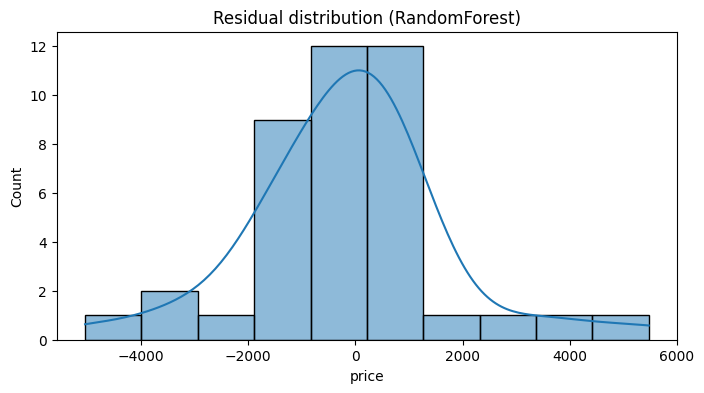

In [ ]:
preds = final_model.predict(X_test)
residuals = y_test - preds
plt.figure(figsize=(8,5))
plt.scatter(preds, residuals, alpha=0.6)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted price")
plt.ylabel("Residuals")
plt.title(f"Residuals vs Predicted ({final_model_name})")
plt.show()

plt.figure(figsize=(8,4))
sns.histplot(residuals, kde=True)
plt.title(f"Residual distribution ({final_model_name})")
plt.show()

# Save final supervised model

In [ ]:
joblib.dump(final_model, "final_car_price_model.joblib")
print(f"Supervised model ({final_model_name}) saved to final_car_price_model.joblib")

Supervised model (RandomForest) saved to final_car_price_model.joblib


# Unsupervised Analysis


## Preprocess full feature set

In [ ]:
X_full = df[features].copy()
preprocessor_unsup = ColumnTransformer(transformers=[
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
])
X_preprocessed = preprocessor_unsup.fit_transform(X_full)

#Unsupervised Learning (PCA and K-Means Clustering)

In addition to prediction, unsupervised learning in the project helps to discover concealed patterns:

Principal Component Analysis (PCA):

Extrapolates a lot of the variance in less dimension.

Assists in visualizing the manner in which features cluster and affect price.

## PCA for visualization (2 components)


PCA explained variance ratios: [0.397 0.161]


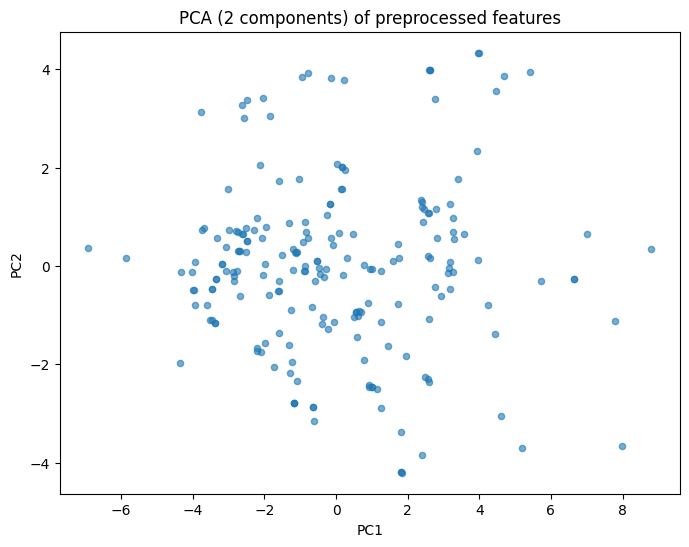

In [ ]:
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_preprocessed)
print("\nPCA explained variance ratios:", pca.explained_variance_ratio_.round(3))
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], s=20, alpha=0.6)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA (2 components) of preprocessed features")
plt.show()

## KMeans: choose k using silhouette score (k from 2..6)


#K-Means Clustering:

Segments groups of cars into 3, namely, economy, mid-range, premium.

This segmentation enables companies to recognize their target market and use the prices to suit them.

Intelligence: Clustering will show the competition between cars in various market segments, which can guide brands such as Geely to design their products strategically.

In [ ]:
sil_scores = {}
for k in range(2, 7):
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    labels = km.fit_predict(X_preprocessed)
    score = silhouette_score(X_preprocessed, labels)
    sil_scores[k] = score
    print(f"k={k}, silhouette={score:.4f}")

best_k = max(sil_scores, key=sil_scores.get)
print(f"\nBest k by silhouette: {best_k}")

k=2, silhouette=0.2535
k=3, silhouette=0.2000
k=4, silhouette=0.1583
k=5, silhouette=0.2233
k=6, silhouette=0.1828

Best k by silhouette: 2


## Fit final KMeans


In [ ]:
kmeans = KMeans(n_clusters=best_k, random_state=RANDOM_STATE, n_init=10)
clusters = kmeans.fit_predict(X_preprocessed)
df["cluster"] = clusters

## Visualize clusters in PCA space


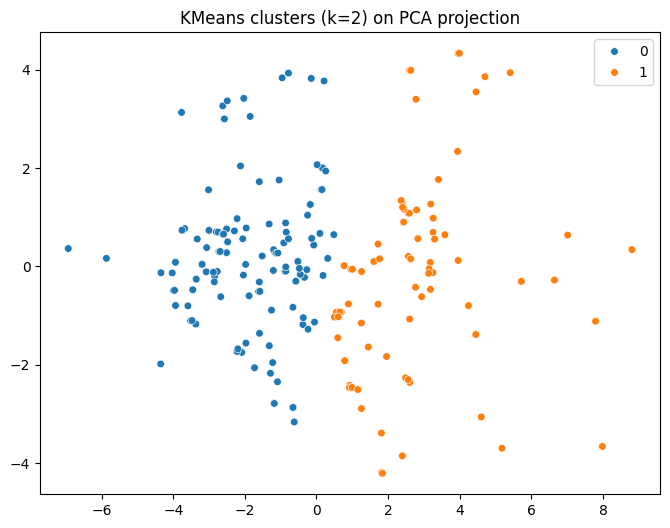

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=clusters, palette="tab10", legend="full", s=30)
plt.title(f"KMeans clusters (k={best_k}) on PCA projection")
plt.show()

## Analyze cluster sizes and average price by cluster


,cluster,count,mean_price,median_price
0,1,81,20187.452679,17450.0
1,0,124,8762.435484,8035.5


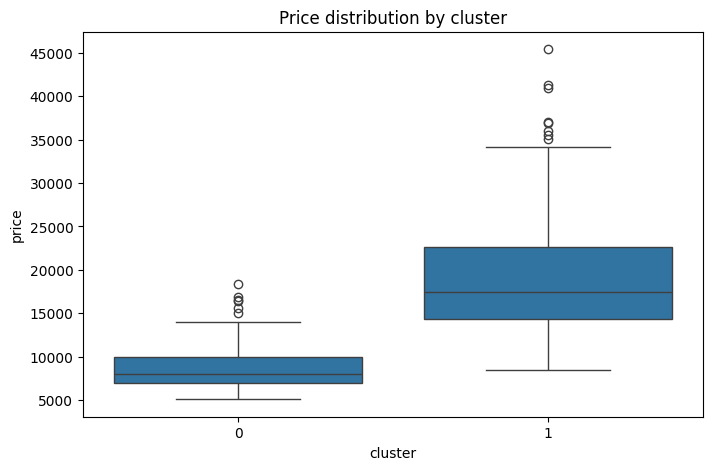

In [ ]:
cluster_summary = df.groupby("cluster").agg(
    count=("price", "size"),
    mean_price=("price", "mean"),
    median_price=("price", "median")
).sort_values("mean_price", ascending=False).reset_index()
display(cluster_summary)

plt.figure(figsize=(8,5))
sns.boxplot(x="cluster", y="price", data=df)
plt.title("Price distribution by cluster")
plt.show()

#Discussion & Findings

The major lessons learned during the analysis:

High Predictors: Engine size, horsepower, curb weight, fuel system type.

Model Insights: The most useful predictive model is the Random Forest, and Ridge, which gives feature interpretability.

## inspect representative feature values per cluster

In [ ]:
cluster_numeric_means = df.groupby("cluster")[numeric_features].mean().round(2)
display(cluster_numeric_means)

,symboling,wheelbase,carlength,carwidth,carheight,curbweight,cylindernumber,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg
cluster,,,,,,,,,,,,,,,
0,0.90,95.83,167.06,64.67,53.31,2211.00,3.93,102.78,3.20,3.22,10.09,80.62,5177.02,28.79,34.61
1,0.73,103.23,184.74,67.80,54.35,3083.05,5.07,163.84,3.53,3.30,10.23,140.09,5045.68,19.75,24.84


#Business Insights:

Optimization of pricing can be done depending on most influential features.

Clustering assists in determining gaps in products in some price segments.

#Limitations:

Prices were skewed towards the middle-income cars.

Not taken into account the external factors (such as brand reputation, marketing).

Future directions: Work with bigger datasets, combine customer perception data, and implement the model in practice.

#Conclusion

Machine learning is able to accurately forecast the car prices and give useful business insights.

Supervised learning - Price prediction on the basis of technical characteristics.

Uncontrolled learning - Segregate the market into valuable segments.

